In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('paper')
import reboundx
from multiprocessing import Pool   
from celmech.disturbing_function import get_fg_coeffs
from celmech import Andoyer, Poincare
from celmech.resonances import resonant_period_ratios, resonance_pratio_span
from celmech.nbody_simulation_utilities import set_timestep,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
from celmech.nbody_simulation_utilities import reb_add_from_elements
import rebound as rb
from celmech.secular import LaplaceLagrangeSystem
from subprocess import call

In [2]:
def sec(sim, i1, i2):
    if i1 > i2:
        raise AttributeEror("i2 must be exterior body")
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    ps = sim.particles
    res = {}
    pvars = Poincare.from_Simulation(sim)
    res['Lambda'] = np.array([p.Lambda for p in pvars.particles[1:]])
    res['Gamma'] = np.array([p.Gamma for p in pvars.particles[1:]])
    res['L10'] = res['Lambda'][i1-1]
    res['L20'] = res['Lambda'][i2-1]
    res['L12'] = res['L10'] + res['L20']
    res['Lr'] = res['L10']*res['L20']/res['L12']
    res['psi'] = np.pi + np.arcsin(np.sqrt(res['L10']/res['L12']))
    res['R'] = np.identity(res['Lambda'].shape[0]) # Nplanets x Nplanets rotation matrix
    # Only rotate the 2x2 submatrix corresponding to i1 and i2 with rotation matrix
    res['R'][np.ix_([i1-1,i2-1],[i1-1, i2-1])] = np.array([[np.cos(res['psi']), -np.sin(res['psi'])], [np.sin(res['psi']), np.cos(res['psi'])]])
    res['Gammax'] = np.sqrt(2*res['Gamma'])*np.cos([p.gamma for p in pvars.particles[1:]]) # gamma = -pomega
    res['Gammay'] = np.sqrt(2*res['Gamma'])*np.sin([p.gamma for p in pvars.particles[1:]])
    res['M'] = lsys.Neccentricity_matrix # no longer normalized
    res['S'] = np.identity(res['Lambda'].shape[0])*np.sqrt(res['Lr']) # Nplanets x Nplanets rotation matrix
    for i, L in enumerate(res['Lambda']):
        res['S'][i,i] /= np.sqrt(L)
    eigvals= lsys.eccentricity_eigenvalues()
    res['Tsec'] = np.abs(2 * np.pi / eigvals)
    return res

def two_planets_eigen(seed, P12, etilde, mu):
    np.random.seed(seed)
    ec = 1 - P12**(2/3)
    e = etilde*ec

    sim = rb.Simulation()
    sim.add(m=1)
    reb_add_from_elements(m=mu/3, elements={'P':1}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12, 'M':np.pi}, sim=sim)
    sim.move_to_com()

    secsim = sec(sim, 1, 2)
    Mprime = secsim['R'] @ secsim['M'] @ secsim['R'].T
    vals,T = np.linalg.eigh(Mprime)
    freqs = np.diag(np.diag(vals))
    
    # initialize in e- eigenmode
    A = [1,0]
    v0 = T @ A
    v0 /= np.linalg.norm(v0)
    
    zstar = secsim['S'] @ secsim['R'].T @ v0
    zstar = zstar/(zstar[1]-zstar[0]) # normalize so em12 = 1
    
    sim = rb.Simulation()
    sim.add(m=1)
    reb_add_from_elements(m=mu/3, elements={'P':1,'e':abs(zstar[0])*e, 'pomega':np.arccos(np.sign(zstar[0])), 'M':np.random.random()*2*np.pi}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12,'e':abs(zstar[1])*e, 'pomega':np.arccos(np.sign(zstar[1])), 'M':np.random.random()*2*np.pi}, sim=sim)
    
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision="direct"
    ps = sim.particles
    minTperi = ps[1].P*(1-ps[1].e)**1.5/(1+ps[1].e)**0.5
    sim.dt = minTperi/20
    
    for p in ps[1:]:
        p.r = p.a*(p.m/3)**(1/3)
        
    return sim

def megno_two_planets_eigen(params):
    seed, P12, etilde, mu, tmax = params
    sim = two_planets_eigen(seed, P12, etilde, mu)
    if tmax is None:
        lsys = LaplaceLagrangeSystem.from_Simulation(sim)
        eigvals = lsys.eccentricity_eigenvalues()
        Tsec = np.min(np.abs(2 * np.pi / eigvals)) # Take shorter one since longer one very large due to ecom conserv.
        tmax = 3*Tsec
        #print("{0:3e}".format(tmax))
    sim.init_megno()
    try:
        sim.integrate(tmax)
    except:
        megno = 1000
        return megno
    megno = sim.calculate_megno()
    if np.isnan(megno):
        megno = 1000
    return megno

In [3]:
def get_pool_params(xlist, ylist, mu=1e-4, tmax=None):
    params = []
    ctr = 0
    for y in ylist:
        for x in xlist:
            params.append((ctr, x, y, mu, tmax))
            ctr += 1
    return params
             
def get_centered_grid(xlist, ylist, poolresults):  
    # assumes uniformly spaced values in x and y (can have different lengths)
    dx = xlist[1]-xlist[0]
    dy = ylist[1]-ylist[0]

    xgrid = [x - dx/2 for x in xlist] + [xlist[-1]+dx/2]
    ygrid = [y - dy/2 for y in ylist] + [ylist[-1]+dy/2]

    X, Y = np.meshgrid(xgrid, ygrid)
    Z = np.array(poolresults).reshape(len(ylist),len(xlist))

    return X,Y,Z

def relativelyprime(num1, num2):
    mn = min(num1, num2) 
    for i in range(1, mn+1): 
         if num1%i==0 and num2%i==0: 
             hcf = i 
    if hcf == 1: 
         return True
    else: 
         return False

In [4]:
mu=1e-5
emax = 1
P12 = 0.63
eps = 2*mu/3
Pmin = 1/1.07# 1/(1+3/2*1.46*(eps)**(2/7))
Pmax = 1/2
NPs = 960
Nes = 80
P23s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, emax, Nes)

deltas = (1-P23s**(2/3))/(2*mu/3)**(1/4)
etildespred2p = 0.72*np.exp(-1.4*deltas**(-4/3))#np.exp(-2.2*deltas**(-4/3))#
f = (1 + 0.65**(-1/3)/(1 + P12**(1/3)))**(-1/2)
etildespred3p = etildespred2p * f/np.sqrt(3)

In [5]:
%%time
params2p = get_pool_params(P23s, etildes, mu=mu, tmax=None)
pool = Pool()
results2p = pool.map(megno_two_planets_eigen, params2p)
np.save('2p1Mearth.npy', results2p)

CPU times: user 54.3 s, sys: 36.8 s, total: 1min 31s
Wall time: 9h 57min 32s


In [14]:
mu=1e-5
emax = 0.4
P12 = 0.63
eps = 2*mu/3
Pmin = 1/1.07# 1/(1+3/2*1.46*(eps)**(2/7))
Pmax = 1/1.16
NPs = 960
Nes = 320
P23s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, emax, Nes)

deltas = (1-P23s**(2/3))/(2*mu/3)**(1/4)
etildespred2p = 0.72*np.exp(-1.4*deltas**(-4/3))#np.exp(-2.2*deltas**(-4/3))#
f = (1 + 0.65**(-1/3)/(1 + P12**(1/3)))**(-1/2)
etildespred3p = etildespred2p * f/np.sqrt(3)

In [15]:
%%time
params2p = get_pool_params(P23s, etildes, mu=mu, tmax=None)
pool = Pool()
results2p = pool.map(megno_two_planets_eigen, params2p)
np.save('2p1Mearth_inset.npy', results2p)

CPU times: user 56.2 s, sys: 2min 25s, total: 3min 21s
Wall time: 1h 45min 2s


In [30]:
mu=1e-4
emax = 1
P12 = 0.63
eps = 2*mu/3
Pmin = 1/1.15# 1/(1+3/2*1.46*(eps)**(2/7))
Pmax = 1/2
NPs = 960
Nes = 160
P23s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, emax, Nes)

deltas = (1-P23s**(2/3))/(2*mu/3)**(1/4)
etildespred2p = 0.72*np.exp(-1.4*deltas**(-4/3))#np.exp(-2.2*deltas**(-4/3))#
f = (1 + 0.65**(-1/3)/(1 + P12**(1/3)))**(-1/2)
etildespred3p = etildespred2p * f/np.sqrt(3)

In [ ]:
%%time
params2p = get_pool_params(P23s, etildes, mu=mu, tmax=None)
pool = Pool()
results2p = pool.map(megno_two_planets_eigen, params2p)
np.save('2p10Mearth.npy', results2p)

In [16]:
mu=1e-4
emax = 0.4
P12 = 0.63
eps = 2*mu/3
Pmin = 1/1.15# 1/(1+3/2*1.46*(eps)**(2/7))
Pmax = 1/1.33
NPs = 960
Nes = 320
P23s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, emax, Nes)

deltas = (1-P23s**(2/3))/(2*mu/3)**(1/4)
etildespred2p = 0.72*np.exp(-1.4*deltas**(-4/3))#np.exp(-2.2*deltas**(-4/3))#
f = (1 + 0.65**(-1/3)/(1 + P12**(1/3)))**(-1/2)
etildespred3p = etildespred2p * f/np.sqrt(3)

In [17]:
%%time
params2p = get_pool_params(P23s, etildes, mu=mu, tmax=None)
pool = Pool()
results2p = pool.map(megno_two_planets_eigen, params2p)
np.save('2p10Mearth_inset.npy', results2p)

CPU times: user 41.7 s, sys: 1min 49s, total: 2min 31s
Wall time: 53min 8s


In [23]:
mu=3e-3
emax = 0.4
P12 = 0.63
eps = 2*mu/3
Pmin = 1/1.5# 1/(1+3/2*1.46*(eps)**(2/7))
Pmax = 1/2
NPs = 960
Nes = 320
P23s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, emax, Nes)

deltas = (1-P23s**(2/3))/(2*mu/3)**(1/4)
etildespred2p = 0.72*np.exp(-1.4*deltas**(-4/3))#np.exp(-2.2*deltas**(-4/3))#
f = (1 + 0.65**(-1/3)/(1 + P12**(1/3)))**(-1/2)
etildespred3p = etildespred2p * f/np.sqrt(3)

In [24]:
%%time
params2p = get_pool_params(P23s, etildes, mu=mu, tmax=2e4)
pool = Pool()
results2p = pool.map(megno_two_planets_eigen, params2p)
np.save('2p1Mjupinset.npy', results2p)

CPU times: user 2min 5s, sys: 6min 33s, total: 8min 39s
Wall time: 2h 41min 10s


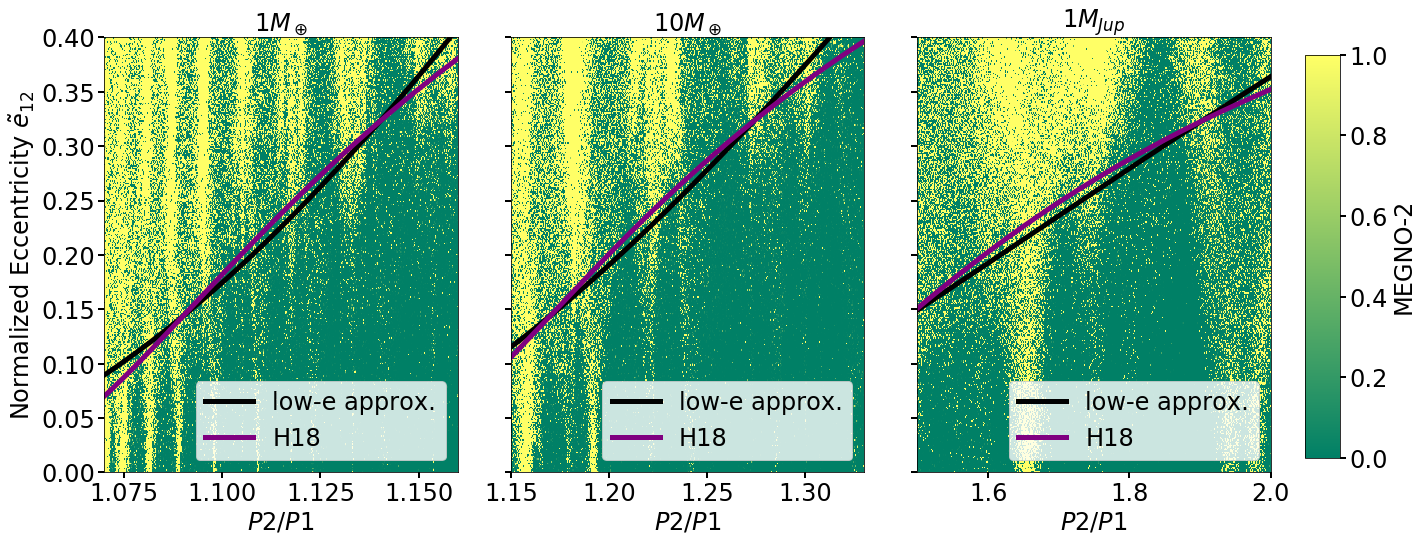

In [4]:
plt.style.use('paper')
fig, axarr = plt.subplots(figsize=(24,8), ncols=3, sharey=True)

ax = axarr[0]

mu=1e-5
emax = 0.4
P12 = 0.63
eps = 2*mu/3
Pmin = 1/1.07# 1/(1+3/2*1.46*(eps)**(2/7))
Pmax = 1/1.16
NPs = 960
Nes = 320
P23s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, emax, Nes)

deltas = (1-P23s**(2/3))/(2*mu/3)**(1/4)
res2p = np.load('2p1Mearth_inset.npy')

X,Y,Z = get_centered_grid(1/P23s, etildes, np.array(res2p)-2)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1, cmap="summer", rasterized=True)
ax.plot(1/P23s, (deltas/2.9)**2, color='k', lw=5, label='low-e approx.')
ax.plot(1/P23s, np.exp(-2.2*deltas**(-4/3)), lw=5, color='purple', label='H18')
ax.legend(loc='lower right', fontsize=24)

ax.set_xlim([(1/P23s).min(), (1/P23s).max()])
ax.set_ylim([etildes.min(), etildes.max()])
ax.set_ylabel(r'Normalized Eccentricity $\tilde{e}_{\rm{12}}}$', fontsize=24)
ax.set_xlabel(r"$P2/P1$", fontsize=24)
ax.set_title(r"$1 M_\oplus$", fontsize=24)
ax = axarr[1]

mu=1e-4
emax = 0.4
P12 = 0.63
eps = 2*mu/3
Pmin = 1/1.15# 1/(1+3/2*1.46*(eps)**(2/7))
Pmax = 1/1.33
NPs = 960
Nes = 320
P23s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, emax, Nes)

deltas = (1-P23s**(2/3))/(2*mu/3)**(1/4)
res2p = np.load('2p10Mearth_inset.npy')

X,Y,Z = get_centered_grid(1/P23s, etildes, np.array(res2p)-2)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1, cmap="summer", rasterized=True)
#ax.plot(1/P23s, P23s**(1/3)/9.24*deltas**2, label='quad')
ax.plot(1/P23s, (deltas/2.9)**2, color='k', lw=5, label='low-e approx.')
ax.plot(1/P23s, np.exp(-2.2*deltas**(-4/3)), lw=5, color='purple', label='H18')
ax.legend(loc='lower right', fontsize=24)

ax.set_xlim([(1/P23s).min(), (1/P23s).max()])
ax.set_ylim([etildes.min(), etildes.max()])
ax.set_xlabel(r"$P2/P1$", fontsize=24)
ax.set_title(r"$10 M_\oplus$", fontsize=24)

ax = axarr[2]

mu=3e-3
emax = 0.4
P12 = 0.63
eps = 2*mu/3
Pmin = 1/1.5# 1/(1+3/2*1.46*(eps)**(2/7))
Pmax = 1/2
NPs = 960
Nes = 320
P23s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, emax, Nes)

deltas = (1-P23s**(2/3))/(2*mu/3)**(1/4)
res2p = np.load('2p1Mjupinset.npy')

X,Y,Z = get_centered_grid(1/P23s, etildes, np.array(res2p)-2)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1, cmap="summer", rasterized=True)
#ax.plot(1/P23s, P23s**(1/3)/9.24*deltas**2, label='quad')
ax.plot(1/P23s, (deltas/2.9)**2, color='k', lw=5, label='low-e approx.')
ax.plot(1/P23s, np.exp(-2.2*deltas**(-4/3)), lw=5, color='purple', label='H18')
ax.legend(loc='lower right', fontsize=24)

ax.set_xlabel(r"$P2/P1$", fontsize=24)

ax.set_xlim([(1/P23s).min(), (1/P23s).max()])
ax.set_ylim([etildes.min(), etildes.max()])
ax.set_title(r"$1 M_{Jup}$", fontsize=24)

fig.subplots_adjust(right=0.8, wspace=0.15)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
#cbar_ax.axis('off')
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("MEGNO-2", fontsize=24)
cb.ax.tick_params(labelsize=24)

for ax in axarr:
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    
fig.savefig('critcomp.pdf')

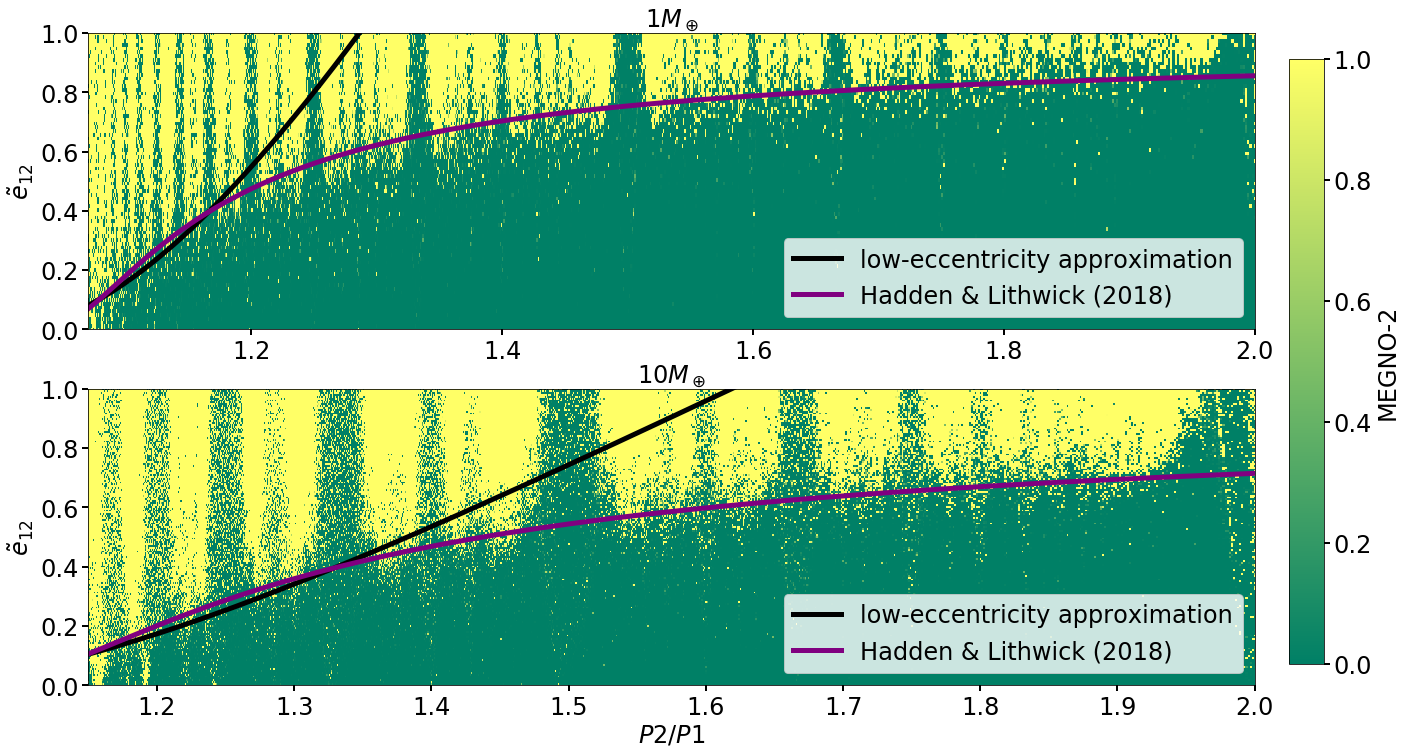

In [5]:
fig, axarr = plt.subplots(figsize=(24,12), nrows=2)

ax = axarr[0]

mu=1e-5
emax = 1
P12 = 0.63
eps = 2*mu/3
Pmin = 1/1.07# 1/(1+3/2*1.46*(eps)**(2/7))
Pmax = 1/2
NPs = 960
Nes = 80
P23s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, emax, Nes)

deltas = (1-P23s**(2/3))/(2*mu/3)**(1/4)
res2p = np.load('2p1Mearth.npy')

X,Y,Z = get_centered_grid(1/P23s, etildes, np.array(res2p)-2)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1, cmap="summer", rasterized=True)
#ax.plot(1/P23s, P23s**(1/3)/9.24*deltas**2, label='quad')
ax.plot(1/P23s, 1/9.24*deltas**2, color='k', lw=5, label='low-eccentricity approximation')
ax.plot(1/P23s, np.exp(-2.2*deltas**(-4/3)), lw=5, color='purple', label='Hadden & Lithwick (2018)')
ax.legend(loc='lower right', fontsize=24)

ax.set_ylabel(r"$\tilde{e}_{12}$", fontsize=24)
ax.set_title(r"$1 M_\oplus$", fontsize=24)

ax.set_xlim([(1/P23s).min(), (1/P23s).max()])
ax.set_ylim([etildes.min(), etildes.max()])

ax = axarr[1]

mu=1e-4
emax = 1
P12 = 0.63
eps = 2*mu/3
Pmin = 1/1.15# 1/(1+3/2*1.46*(eps)**(2/7))
Pmax = 1/2
NPs = 960
Nes = 160
P23s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, emax, Nes)

deltas = (1-P23s**(2/3))/(2*mu/3)**(1/4)
res2p = np.load('2p10Mearth.npy')

X,Y,Z = get_centered_grid(1/P23s, etildes, np.array(res2p)-2)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1, cmap="summer", rasterized=True)
#ax.plot(1/P23s, P23s**(1/3)/9.24*deltas**2, label='quad')
ax.plot(1/P23s, 1/9.24*deltas**2, color='k', lw=5, label='low-eccentricity approximation')
ax.plot(1/P23s, np.exp(-2.2*deltas**(-4/3)), lw=5, color='purple', label='Hadden & Lithwick (2018)')
ax.legend(loc='lower right', fontsize=24)
ax.set_xlabel(r"$P2/P1$", fontsize=24)
ax.set_ylabel(r"$\tilde{e}_{12}$", fontsize=24)
ax.set_title(r"$10 M_\oplus$", fontsize=24)

ax.set_xlim([(1/P23s).min(), (1/P23s).max()])
ax.set_ylim([etildes.min(), etildes.max()])

fig.subplots_adjust(right=0.8, wspace=0.15)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
#cbar_ax.axis('off')
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("MEGNO-2", fontsize=24)
cb.ax.tick_params(labelsize=24)

for ax in axarr:
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    
fig.savefig('critcompwide.pdf')